In [39]:
import numpy as np
from matplotlib import pyplot as plt
import os
import cv2 
import tensorflow as tf
import pydicom
from sklearn.model_selection import train_test_split
import joblib

In [40]:
def read_csv_data(path_to_file):
    """
    Reads the CSV file and returns a list of lists containing the data
    """
    X = []
    Y = []
    with open(path_to_file, 'r') as f:
        data = f.readlines()
    for i in range(len(data)):
        csv_data = data[i].split(';')
        y_value = 1 if csv_data[1] == '1\n' else 0
        X.append(csv_data[0])
        Y.append(y_value)
    print(X[791])
    return np.array(X), np.array(Y)

In [41]:
csv_info = read_csv_data('data/dental_base.csv')

792


In [43]:
def read_all_train_images(folder_path, csv_info):
    """
    Reads all the images in the folder and returns a list of images
    """
    num_files = len(csv_info[0])
    images_np = np.zeros((num_files, 100, 100), dtype=np.uint8)
    valid_indices = [] 

    for i, filename in enumerate(csv_info[0]):
        img_path = os.path.join(folder_path, f"{filename}.jpg")
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (100, 100))
        images_np[i] = img
        img = img.flatten()
        if np.std(img) != 0:
            valid_indices.append(i)
    print(f"Number of valid images: {len(valid_indices)}")
    print(len(images_np))
    X = images_np[valid_indices]
    Y = csv_info[1][valid_indices]
    return X, Y


In [44]:
X, Y = read_all_train_images('data/photos', csv_info)

Number of valid images: 942
942


In [45]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8)

In [46]:
x_train = x_train.reshape(x_train.shape[0], -1)
print(x_train.shape)

(753, 10000)


In [47]:
x_test = x_test.reshape(x_test.shape[0], -1)
print(x_test.shape)

(189, 10000)


In [48]:
def normalize_data(data):
    mean_of_each_image = data.mean(axis=0)
    data_normalized = data - mean_of_each_image
    return data_normalized

In [49]:
def pca(data, h, w, approximation=0.85):
    data_normalized = normalize_data(data)
    
    print("Step 1 - Find the covariance matrix") 
    covariance_matrix = np.cov(data_normalized, rowvar=False)
    
    print("Step 2 - Find the eigenvalues and eigenvectors of the covariance matrix") 
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    
    print("Step 3 - Sort the eigenvalues and eigenvectors in descending order") 
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    
    print("Step 4 - Find the number of principal components that explain the given approximation") 
    total_variance = np.sum(eigenvalues)
    variance_explained = eigenvalues / total_variance
    cumulative_variance_explained = np.cumsum(variance_explained)
    number_of_components = np.argmax(cumulative_variance_explained >= approximation) + 1
    
    print("Step 6 - Find the principal components") 
    principal_components = eigenvectors[:, :number_of_components]
    return principal_components, data_normalized, number_of_components, cumulative_variance_explained

In [50]:
def transform_data(data, principal_components):
    return data.dot(principal_components)

In [51]:
principal_components, data_normalized, number_of_components, cumulative_variance_explained = pca(x_train, 100, 100, 0.85)


Step 1
Step 2
Step 3
Step 4
Step 6


In [52]:
with open("./model_data/principal_components.npy", "wb") as f:
    np.save(f, principal_components)

In [53]:
final_data_normalized_reduced = transform_data(x_train, principal_components)

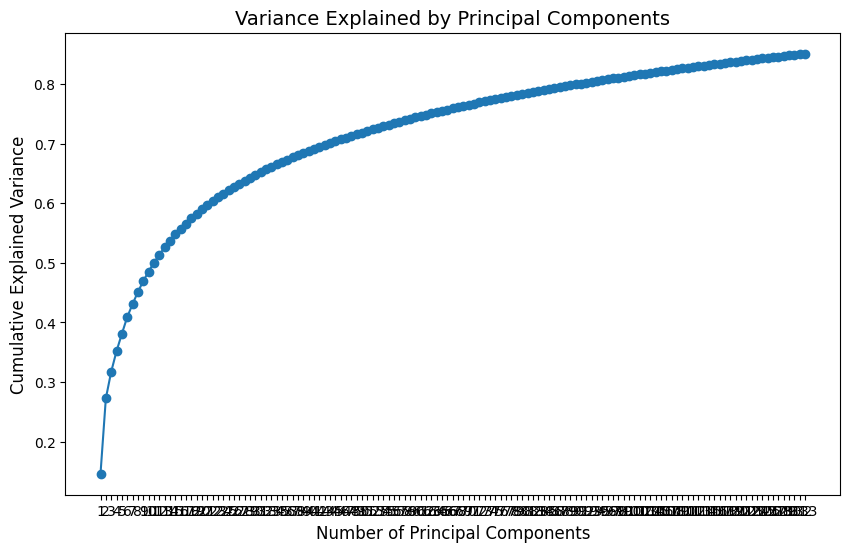

In [58]:
def plot_variance_explained(cumulative_variance_explained, number_of_components):
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(1, number_of_components + 1), cumulative_variance_explained[:number_of_components], '-o')
    plt.xticks(np.arange(1, number_of_components + 1))
    plt.xlabel('Number of Principal Components', fontsize=12)
    plt.ylabel('Cumulative Explained Variance', fontsize=12)
    plt.title('Variance Explained by Principal Components', fontsize=14)
    plt.show()

plot_variance_explained(cumulative_variance_explained, number_of_components)


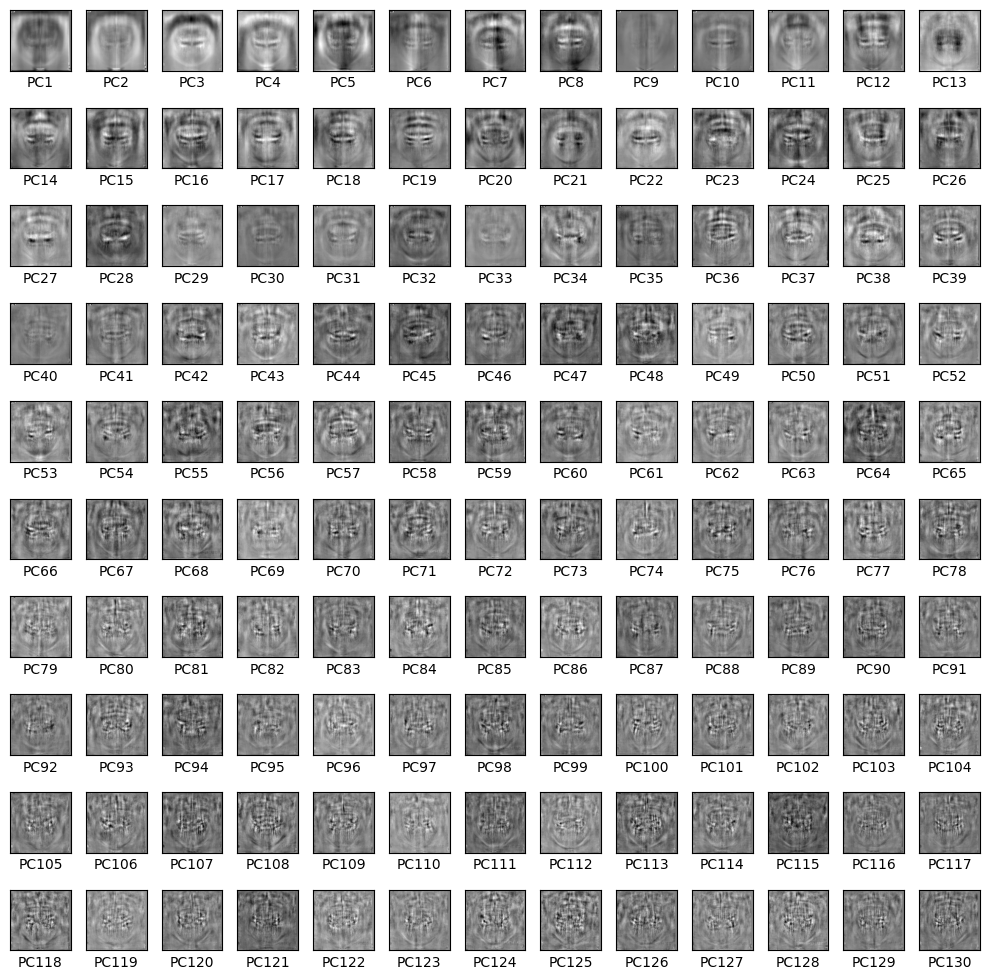

In [59]:
def plot_principal_components(principal_components, im_shape=(100, 100), n_row=10, n_col=None):
    if n_col is None:
        n_col = principal_components.shape[1] // n_row

    fig, axes = plt.subplots(n_row, n_col, figsize=(10, 10))
    axes = axes.ravel()

    for i, axi in enumerate(axes):
        if i < principal_components.shape[1]:
            img = principal_components[:, i].reshape(im_shape)
            axi.imshow(img, cmap="gray")
            axi.set_xlabel(f"PC{i+1}")
            axi.set_xticks([])
            axi.set_yticks([])
        else:
            axi.axis('off')

    plt.tight_layout()
    plt.show()

plot_principal_components(principal_components)


In [60]:
final_data_normalized_reduced_x_test = transform_data(x_test, principal_components)

In [62]:
def evaluate_model(predicted, true):
    sum = 0
    for i in range(len(predicted)):
        if predicted[i] == true[i]:
            sum+=1
    return sum/len(predicted)

In [63]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(final_data_normalized_reduced, y_train)

DecisionTreeClassifier()

In [64]:
joblib.dump(dtc, 'model_data/decission_tree.pkl')

['model_data/decission_tree.pkl']

In [65]:
y_pred = dtc.predict(final_data_normalized_reduced_x_test)

In [66]:
evaluate_model(y_pred, y_test)

0.656084656084656

In [67]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(final_data_normalized_reduced, y_train)
y_pred = rfc.predict(final_data_normalized_reduced_x_test)

In [68]:
joblib.dump(rfc, 'model_data/Random_Forest.pkl')

['model_data/Random_Forest.pkl']

In [69]:
evaluate_model(y_pred, y_test)

0.7354497354497355

In [70]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(final_data_normalized_reduced, y_train)
y_pred = svc.predict(final_data_normalized_reduced_x_test)

In [71]:
joblib.dump(svc, 'model_data/svc.pkl')

['model_data/svc.pkl']

In [72]:
evaluate_model(y_pred, y_test)

0.656084656084656

In [73]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(final_data_normalized_reduced, y_train)
y_pred = knn.predict(final_data_normalized_reduced_x_test)

In [74]:
y_pred
x_test[16]

array([255, 254, 254, ..., 254, 255, 255], dtype=uint8)

In [75]:
evaluate_model(y_pred, y_test)

0.6878306878306878

In [76]:
joblib.dump(knn, 'model_data/KNeighbors.pkl')


['model_data/KNeighbors.pkl']